### Demo script for exploratory investigation of traces, demonstrates data loading into CosmosTraces object. 
This script does not produce any final figures. 

To run locally, download processed imaging and behavior datasets, and change directory in second cell to specify the file location. 


In [21]:
# Load imports.
%load_ext autoreload
%autoreload 2
%matplotlib inline

from matplotlib import pyplot as plt
import h5py
import numpy as np
import os
import time
from scipy.ndimage.filters import gaussian_filter1d
import scipy.stats

from cosmos.behavior.bpod_dataset import BpodDataset
from cosmos.traces.cosmos_traces import CosmosTraces
import cosmos.params.trace_analyze_params as params 
import cosmos.traces.trace_analysis_utils as utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# Select dataset.

# Specify data location here.
data_dir = '/home/user/Dropbox/cosmos_data/'  # Top level, should contain separate directories for each date.
behavior_dir = '/home/user/Dropbox/cosmos_data/behavior/'
fig_save_dir = '/home/user/Dropbox/cosmos/demo/'

# Set dataset ID here.
dataset_id = 19  # IDs of provided datasets: 7, 11, 18, 19.


# Boiler plate (don't change)
dataset = params.DATASETS[dataset_id]
print(dataset)
dataset['data_root'] = data_dir
dataset['fig_save_dir'] = fig_save_dir
dataset['behavior_dir'] = behavior_dir
os.makedirs(fig_save_dir, exist_ok=True)

{'date': '20180709', 'name': 'cux2ai148m194_COSMOSTrainMultiBlockGNG_2', 'bpod_file': 'cux2m194/COSMOSTrainMultiBlockGNG/Session Data/cux2m194_COSMOSTrainMultiBlockGNG_20180709_134919.mat', 'regressors_name': 'cux2m194-20180709-134705', 'info': '***Reasonable behavior. Around 1400 neurons.'}


(1/3) Loading trace data.
(2/3) Loading behavior data.
While loading bpod, enforcing that ntrials is:200
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
Saving to:  /home/user/Dropbox/cosmos/demo/20180709/cux2ai148m194_COSMOSTrainMultiBlockGNG_2/polar_pre-reward.pdf
Saving to:  /home/user/Dropbox/cosmos/demo/20180709/cux2ai148m194_COSMOSTrainMultiBlockGNG_2/polar_post-reward.pdf
Saving to:  /home/user/Dropbox/cosmos/demo/20180709/cux2ai148m194_COSMOSTrainMultiBlockGNG_2/licks.pdf
Saving to:  /home/user/Dropbox/cosmos/demo/20180709/cux2ai148m194_COSMOSTrainMultiBlockGNG_2/success_rate.pdf
LED trials: 201
Processing traces.
[ 22.0399507 515.9600493]
[393.84706348 347.15293652]
Elapsed time: 23.108407974243164


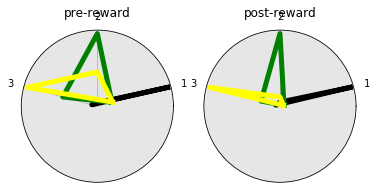

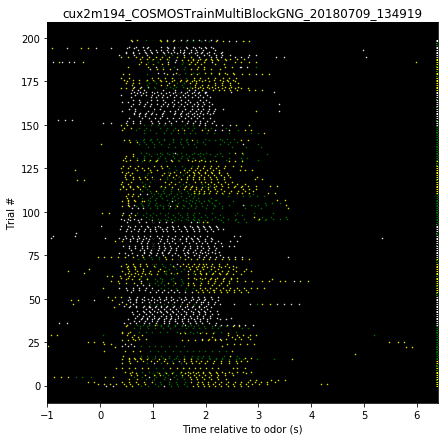

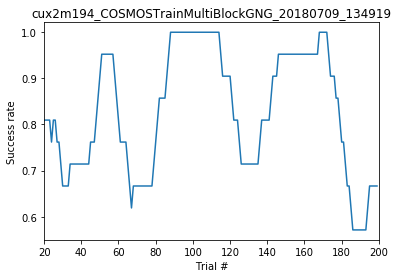

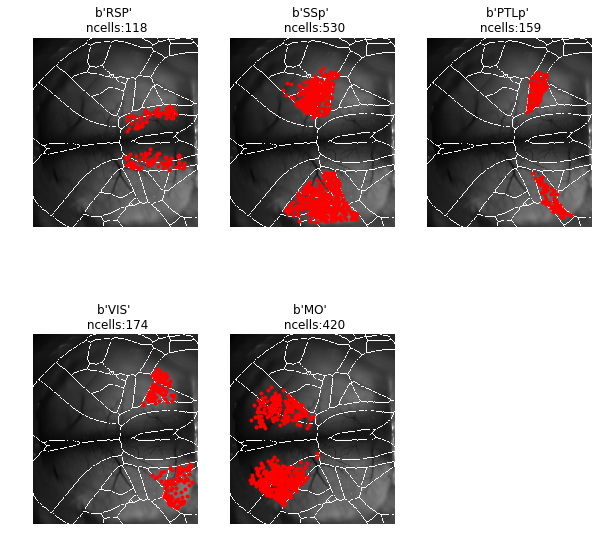

In [23]:
# Load data.
t0 = time.time()

CT = CosmosTraces(dataset, do_region_plots=True)
BD = CT.bd # BpodDataset object containing information about task behavior.

print('Elapsed time: '+str(time.time() - t0))

In [24]:
# Compute session performance.
print('Session performance: {:.3f}'.format(
    np.sum(CT.bd.success)/len(CT.bd.success)))

Session performance: 0.825


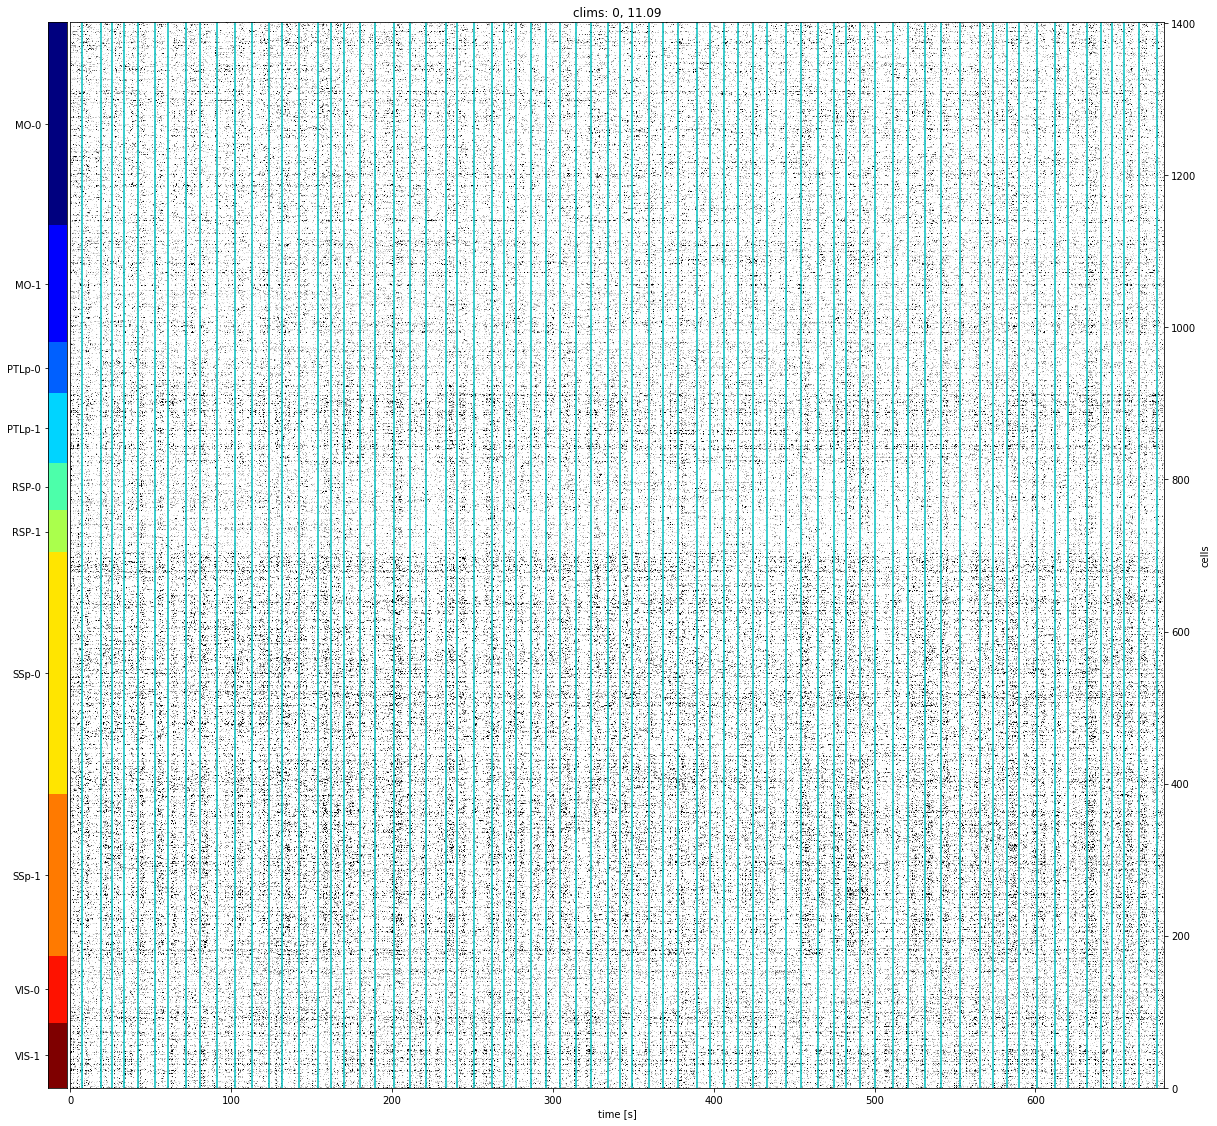

In [25]:
# Plot raster of neural activity, organized by region.
CT.plot_raster_by_region(traces=gaussian_filter1d(CT.S, 2, axis=1), 
                         startframe=0, 
                         nframes=20000, 
                         event_frames=CT.led_frames)
plt.savefig(os.path.join(CT.fig_save_path, 'raster_zoom1.pdf'), 
            transparent=True, rasterized=True, dpi=600)

---Plotting contours: 4.589277505874634 seconds ---


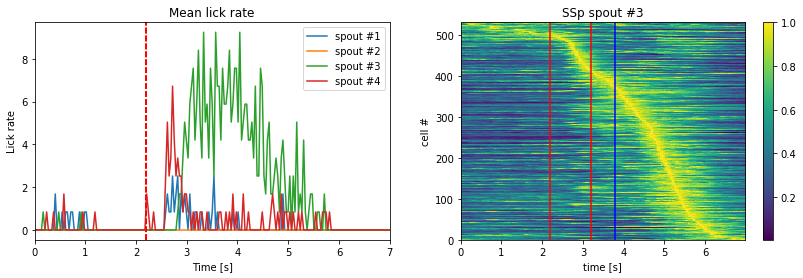

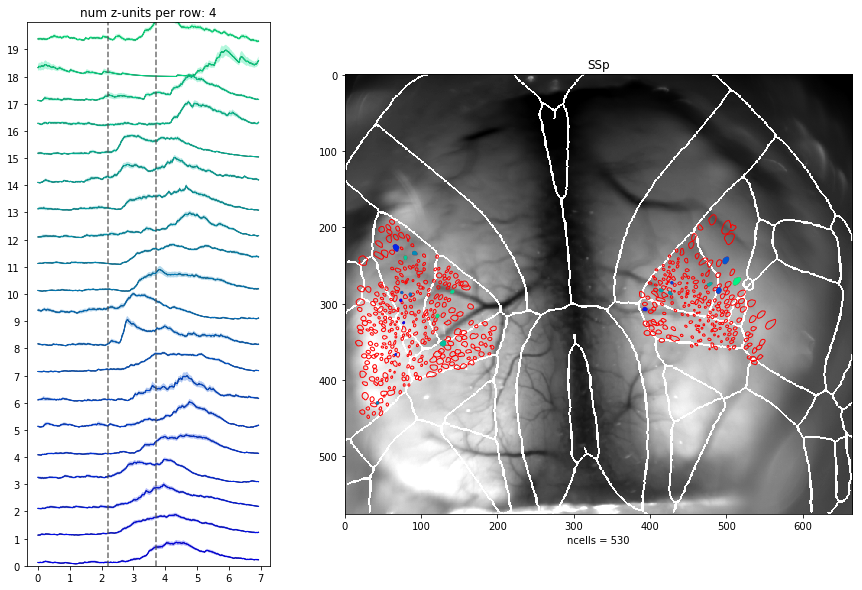

In [26]:
# Make general summary plots for specified cells and trials. 

# Plot footprints and traces cells from a region.
region = 'SSp' # Options are: 'VIS', 'RSP', 'MO', 'PTLp', 'SSp'
hemisphere = None # 0, 1, or None
spout_num = 3 # Options are 1, 3, 4 (Originally, there were 4, not 3, spouts.)
use_all_cells = False # If True, then ignores region selections. 

# Select cells to be plotted.
which_cells = np.array(CT.cells_in_region[CT.regions[region]])
if hemisphere is not None:
    which_cells = which_cells[np.where(
        CT.hemisphere_of_cell[which_cells]==hemisphere)[0]]
if use_all_cells:
    which_cells = np.arange(np.shape(CT.Ct)[0])

# Select trials to be plotted. 
trials = np.logical_and.reduce((BD.go_trials.astype('bool'), 
                                            BD.success, 
                                            BD.spout_positions==spout_num))

# Generate trial averages for specified trials and cells.
trials = trials[:CT.Ct.shape[2]]
traces = CT.Ct[which_cells,:,:][:,:,trials[:]]
footprints = CT.footprints[:,:,which_cells]
trial_means = np.mean(traces, axis=2)
trial_sems = scipy.stats.sem(traces, axis=2)


# Make plots.
plt.figure(figsize=(14,4))
BD.plot_mean_lick_rates(trials, ax=plt.subplot('121'), xlims=[0, 7])
utils.plot_average_trial_raster(trial_means, 
                                bpod_data=CT.bd, 
                                ordering='peak', # Note: not cross-validated.
                                do_normalize=True, 
                                dt = CT.dt,
                                ax=plt.subplot('122'), 
                                title=region+' spout #'+str(spout_num))
CT.plot_variance_shaded_traces(trial_means, trial_sems, 
                               cell_inds=np.arange(10, 30), # Set to change number of plotted sources.
                               footprints=footprints,
                               ordering='var', 
                               title=region) 
plt.savefig(os.path.join(CT.fig_save_path, 'overview.pdf'), 
            transparent=True, rasterized=True, dpi=600)


In [27]:
# Get event frames (i.e. trial start, odor onset, reward onset)
event_frames = CT.fps*np.array([0, BD.stimulus_times[0], 
                                BD.stimulus_times[0]+1.5])

In [28]:
# Get smoothed spikes.
smooth_spikes = gaussian_filter1d(CT.St, sigma=1.5, 
                                  axis=1, mode='constant') # cell x time x trial

In [29]:
# Plot away...